In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import nest

# Only show warnings and errors from NEST
nest.set_verbosity("M_WARNING")



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:59

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Task 1

In [2]:
# Print out useful information about our neuron model:
neuron = nest.Create("iaf_psc_delta")
neuron.get()


{'archiver_length': 0,
 'beta_Ca': 0.001,
 'C_m': 250.0,
 'Ca': 0.0,
 'E_L': -70.0,
 'element_type': 'neuron',
 'frozen': False,
 'global_id': 1,
 'I_e': 0.0,
 'local': True,
 'model': 'iaf_psc_delta',
 'model_id': 21,
 'node_uses_wfr': False,
 'post_trace': 0.0,
 'recordables': ('V_m',),
 'refractory_input': False,
 'synaptic_elements': {},
 't_ref': 2.0,
 't_spike': -1.0,
 'tau_Ca': 10000.0,
 'tau_m': 10.0,
 'tau_minus': 20.0,
 'tau_minus_triplet': 110.0,
 'thread': 0,
 'thread_local_id': -1,
 'V_m': -70.0,
 'V_min': -1.7976931348623157e+308,
 'V_reset': -70.0,
 'V_th': -55.0,
 'vp': 0}

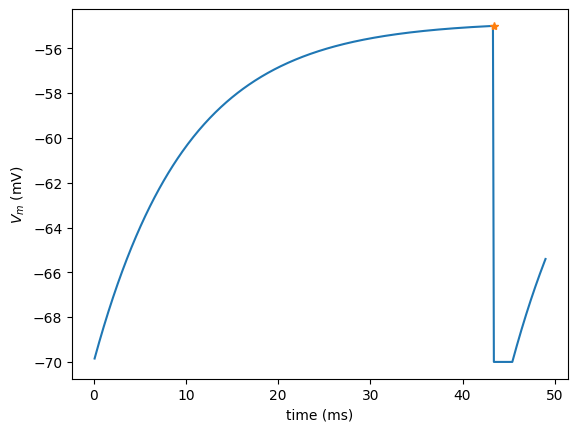

In [3]:

def build_network(I_e, sim_time=50):
    nest.ResetKernel()
    neuron = nest.Create("iaf_psc_delta")
    
    voltmeter = nest.Create("voltmeter")
    spike_recorder = nest.Create("spike_recorder")

    voltmeter.interval = 0.1
    neuron.I_e = I_e
    
    nest.Connect(voltmeter, neuron)
    nest.Connect(neuron, spike_recorder)
    
    nest.Simulate(sim_time)
    
    dSD = spike_recorder.get("events")
    evs = dSD["senders"]
    t_s = dSD["times"]
    num_spikes = len(t_s)
    
    dvm = voltmeter.get()
    Vms = dvm["events"]["V_m"]
    t_vm = dvm["events"]["times"]
    
    plt.close("all")
    plt.subplot(111, xlabel="time (ms)", ylabel="$V_m$ (mV)")
    plt.plot(t_vm, Vms)
    plt.plot(t_s, np.ones(len(t_s)) * (-55), '*')
    return t_s

spikes = build_network(380)

### Task 1.1 by numerical trial and error:

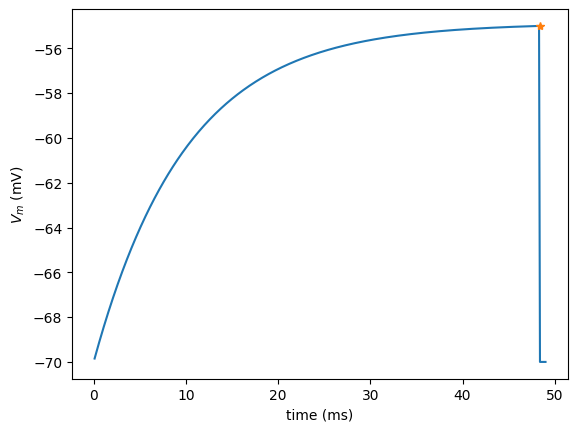

In [4]:
#  Exactly 1 spike, minimum:
spikes = build_network(378)

#  Exactly 1 spike, maximum
# spikes = build_network(412.)

### Task 1.1 by math:
We can also calculate the minimum and maxiumum currents for producing exactly one spike.
From the equation,
\begin{equation}
V(t) = V_0 e^{-t/\tau_m} + \left(E_L + \frac{I_e \tau_m}{C}\right)\left(1-e^{-t/\tau_m}\right),
\end{equation}
we can find the minimum $I_e$ for $V_e$ to reach $V_{th}$ after exactly $t_*$ = 50 ms.


In [5]:
neuron = nest.Create("iaf_psc_delta")
print(neuron.get())

{'archiver_length': 0, 'beta_Ca': 0.001, 'C_m': 250.0, 'Ca': 0.0, 'E_L': -70.0, 'element_type': 'neuron', 'frozen': False, 'global_id': 4, 'I_e': 0.0, 'local': True, 'model': 'iaf_psc_delta', 'model_id': 21, 'node_uses_wfr': False, 'post_trace': 0.0, 'recordables': ('V_m',), 'refractory_input': False, 'synaptic_elements': {}, 't_ref': 2.0, 't_spike': -1.0, 'tau_Ca': 10000.0, 'tau_m': 10.0, 'tau_minus': 20.0, 'tau_minus_triplet': 110.0, 'thread': 0, 'thread_local_id': -1, 'V_m': -70.0, 'V_min': -1.7976931348623157e+308, 'V_reset': -70.0, 'V_th': -55.0, 'vp': 0}


Min I_e for one spike:  377.5438705898642


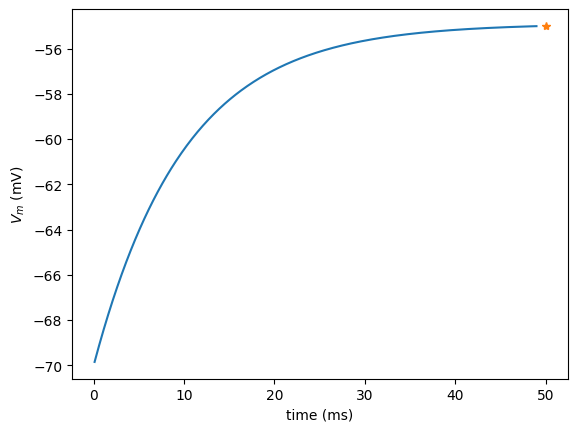

In [6]:
dt = 0.1  # ms
tau_m = neuron.get("tau_m")
C = neuron.get("C_m")
V_th = neuron.get("V_th")
E_L = neuron.get("E_L")
t_star = 50  # ms
I_e_min = C / tau_m * ((V_th - E_L * np.exp(-t_star / tau_m)) / (1 - np.exp(-t_star / tau_m)) - E_L)

print("Min I_e for one spike: ", I_e_min)

spikes = build_network(I_e_min)


The maximum $I_e$ that will give one spike will be the current that is _just_ small enough to not give two spikes.
In this case, we will within 50 ms first drive the neuron to fire one spike, go through one refractory period (2 ms), and (almost) drive the neuron to spike again. We can then use the same formula as above, but with $t_*$ = 24 + dt = 24.1 ms :


Max I_e for one spike:  412.00428634291785


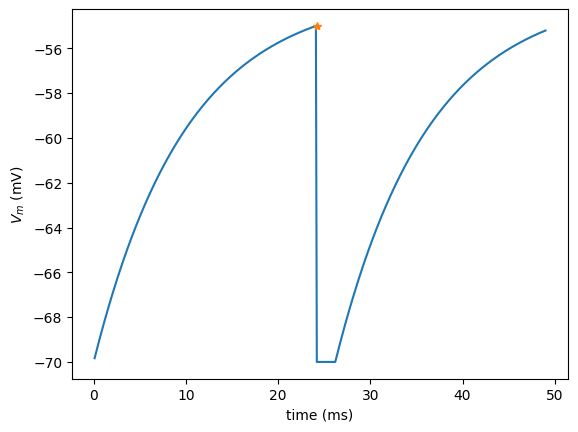

In [7]:
t_star = 24 + dt # ms
I_e_max = C / tau_m * ((V_th - E_L * np.exp(-t_star / tau_m)) / (1 - np.exp(-t_star / tau_m)) - E_L)
spikes = build_network(I_e_max)
print("Max I_e for one spike: ", I_e_max)

### Task 1.2

We implement a simple automated search to find an amplitude that gives exactly 20 spikes:

350.0 0
375.0 0
387.5 27
381.25 23
378.125 20

 I_e = 378.125 pA gave exactly 20 spikes


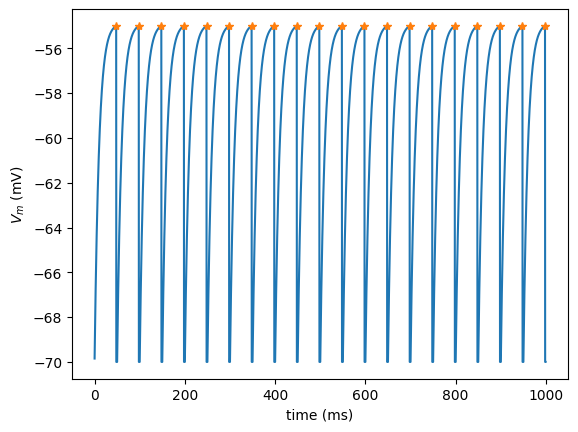

In [8]:
a, b = 300., 400. # Upper and lower bound
n_sp = 0
n_sp_wanted = 20
while n_sp != n_sp_wanted:
    I_e_opt = ( a + b ) / 2
    n_sp = len(build_network(I_e_opt, sim_time=1000))
    
    print(I_e_opt, n_sp)
    if n_sp < n_sp_wanted:
        a = I_e_opt
    else:
        b = I_e_opt

print("")
print(f" I_e = {I_e_opt} pA gave exactly 20 spikes")

plt.close("all")
spikes = build_network(I_e_opt, sim_time=1000)

### Task 1.3

We implement a simple automated search to find an ISI of exactly 20 ms:

587.525 12.2
481.2875 17.2
428.16875000000005 22.900000000000002
454.72812500000003 19.5
441.44843750000007 21.0
448.08828125 20.200000000000003
451.408203125 19.8
449.7482421875 20.0


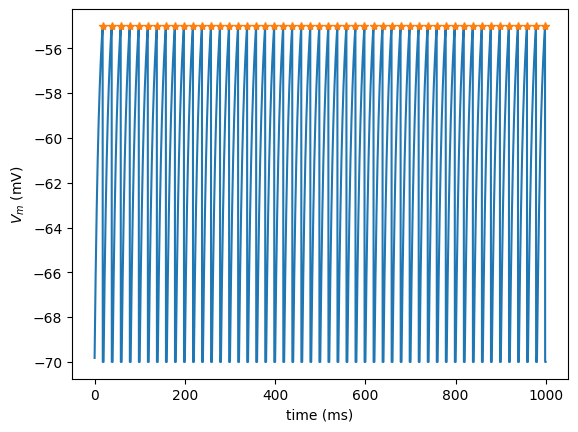

In [9]:
a, b = 375.05, 800.
isi_wanted = 20.

while True:
    I_opt_isi = ( a + b ) / 2
    spiketimes = build_network(I_opt_isi, sim_time=1000)
    
    mean_isi = np.diff(spiketimes).mean()
    print(I_opt_isi, mean_isi)
    if mean_isi == isi_wanted:
        break
    if mean_isi < isi_wanted:
        b = I_opt_isi
    else:
        a = I_opt_isi

## Task 2

[ 18.  38.  58.  78.  98. 118. 138. 158. 178. 198.]
[ 19.1  39.1  59.1  79.1  99.1 119.1 139.1 159.1 179.1 199.1]
[1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1 1.1]


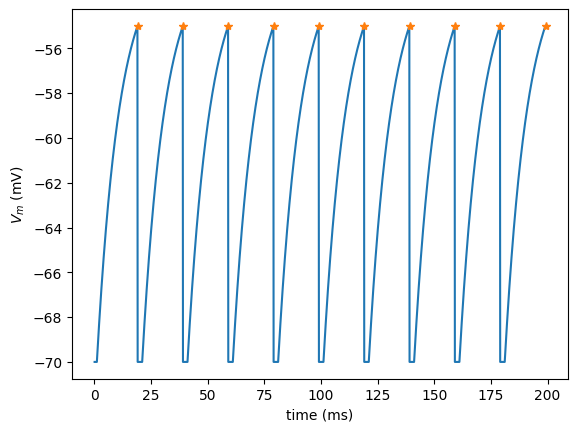

In [10]:
def build_network_noise(I_e, mu, sigma, my_seed, sim_time=50):
    nest.ResetKernel()
    nest.rng_seed = my_seed

    neuron = nest.Create("iaf_psc_delta")
    voltmeter = nest.Create("voltmeter")
    spike_recorder = nest.Create("spike_recorder")
    noise_generator = nest.Create("noise_generator")
    
    noise_generator.mean = mu
    noise_generator.std = sigma
    noise_generator.dt = dt
    voltmeter.interval = 0.1
    neuron.I_e = I_e
    
    nest.Connect(voltmeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(noise_generator, neuron)
    
    nest.Simulate(sim_time)
    
    dSD = spike_recorder.get("events")
    evs = dSD["senders"]
    t_s = dSD["times"]
    num_spikes = len(t_s)
    
    dvm = voltmeter.get()
    Vms = dvm["events"]["V_m"]
    t_vm = dvm["events"]["times"]
    
    plt.close("all")
    plt.subplot(111, xlabel="time (ms)", ylabel="$V_m$ (mV)")
    plt.plot(t_vm, Vms)
    plt.plot(t_s, np.ones(len(t_s)) * (-55), '*')
    return t_s


spikes_1 = build_network(I_opt_isi, sim_time=200)
spikes_2 = build_network_noise(0, I_opt_isi, 0., 1128, sim_time=200)

print(spikes_1)
print(spikes_2)
print(spikes_2 - spikes_1)

### Validation: 
There is a delay of 1.1 ms, because of a 1 ms "connection delay", pluss 1 timestep  

### Task 2.1
Modify the code to return $V_m$ and spike times

In [11]:
def build_network_noise(I_e, mu, sigma, my_seed, sim_time=50):
    nest.ResetKernel()
    nest.rng_seed = my_seed

    neuron = nest.Create("iaf_psc_delta")
    voltmeter = nest.Create("voltmeter")
    spike_recorder = nest.Create("spike_recorder")
    noise_generator = nest.Create("noise_generator")
    
    noise_generator.mean = mu
    noise_generator.std = sigma
    noise_generator.dt = dt
    voltmeter.interval = 0.1
    neuron.I_e = I_e
    
    nest.Connect(voltmeter, neuron)
    nest.Connect(neuron, spike_recorder)
    nest.Connect(noise_generator, neuron)
    
    nest.Simulate(sim_time)
    
    dSD = spike_recorder.get("events")
    evs = dSD["senders"]
    t_s = dSD["times"]
    num_spikes = len(t_s)
    
    dvm = voltmeter.get()
    Vms = dvm["events"]["V_m"]
    t_vm = dvm["events"]["times"]
    

    return t_s, t_vm, Vms


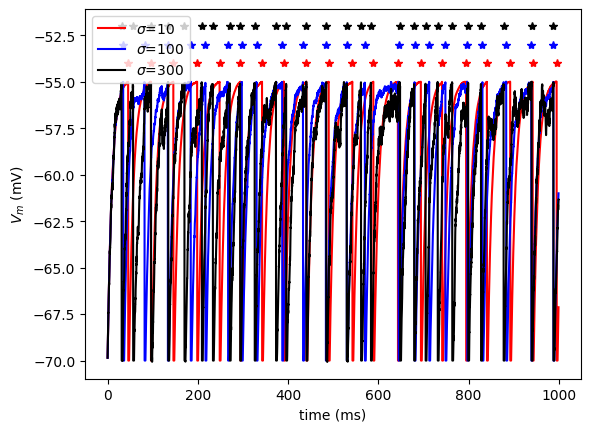

In [12]:
I_e = 378.125  # Gave 20 spikes
my_seed = 1234
mu = 0
t_s_1, t_vm_1, Vms_1 = build_network_noise(I_e, mu, 10, my_seed, sim_time=1000)
t_s_2, t_vm_2, Vms_2 = build_network_noise(I_e, mu, 100, my_seed, sim_time=1000)
t_s_3, t_vm_3, Vms_3 = build_network_noise(I_e, mu, 300, my_seed, sim_time=1000)

plt.subplot(111, xlabel="time (ms)", ylabel="$V_m$ (mV)")

l1, = plt.plot(t_vm_1, Vms_1, 'r', label="$\sigma$=10")
plt.plot(t_s_1, np.ones(len(t_s_1)) * (-54), 'r*')

l2, = plt.plot(t_vm_2, Vms_2, 'b', label="$\sigma$=100")
plt.plot(t_s_2, np.ones(len(t_s_2)) * (-53), 'b*')

l3, = plt.plot(t_vm_3, Vms_3, 'k', label="$\sigma$=300")
plt.plot(t_s_3, np.ones(len(t_s_3)) * (-52), 'k*')

plt.legend()

### Task 2.2


In [13]:
I_e = 378.125  # Gave 20 spikes
my_seed = 1234
mu = 0
t_s_1, t_vm_1, Vms_1 = build_network_noise(I_e, mu, 10, my_seed, sim_time=100000)
t_s_2, t_vm_2, Vms_2 = build_network_noise(I_e, mu, 100, my_seed, sim_time=100000)
t_s_3, t_vm_3, Vms_3 = build_network_noise(I_e, mu, 300, my_seed, sim_time=100000)

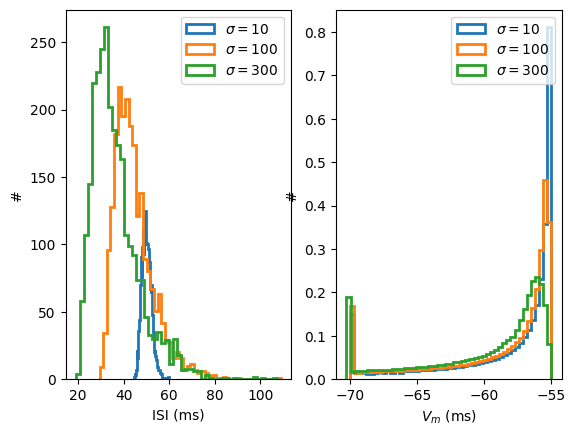

In [14]:
plt.subplot(121, xlabel="ISI (ms)", ylabel="#")

plt.hist(np.diff(t_s_1), bins=50, histtype='step', alpha=1, lw=2, label=r'$\sigma = 10$')
plt.hist(np.diff(t_s_2), bins=50, histtype='step', alpha=1, lw=2, label=r'$\sigma = 100$')
plt.hist(np.diff(t_s_3), bins=50, histtype='step', alpha=1, lw=2, label=r'$\sigma = 300$')
plt.legend()

plt.subplot(122, xlabel="$V_m$ (ms)", ylabel="#")

plt.hist(Vms_1, bins=50, histtype='step', alpha=1, lw=2, label=r'$\sigma = 10$', density=True)
plt.hist(Vms_2, bins=50, histtype='step', alpha=1, lw=2, label=r'$\sigma = 100$', density=True)
plt.hist(Vms_3, bins=50, histtype='step', alpha=1, lw=2, label=r'$\sigma = 300$', density=True)
plt.legend()


As one can expect, a larger variability in the noise causes a broader ISI distribution, that is, the spike times will be less regular, sometimes far apart and sometime close. 

The two peaks in the membrane potential histogram reflects the reset potential (-70 mV) where the neuron is held during the refractory period, and the spike threshold (-55 mV). For a higher variability in the noise, the neurons can spend more time in between, because the membrane potential is pushed up and down. 

### Task 2.3

In [15]:
sigmas = np.linspace(0, 500, 20)
rate = np.zeros(len(sigmas))
sim_time = 100000
for idx, sigma in enumerate(sigmas):
    t_s, t_vm, Vms = build_network_noise(I_e, mu, sigma, my_seed, sim_time=sim_time)
    rate[idx] = len(t_s) / sim_time * 1000

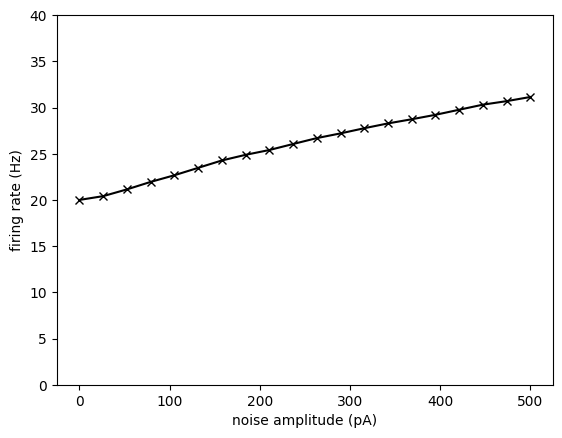

In [16]:
plt.close("all")
plt.subplot(111, xlabel="noise amplitude (pA)", ylabel="firing rate (Hz)", ylim=[0, 40])
plt.plot(sigmas, rate, 'kx-')

Larger noise variability increases firing rate, since strong noise can push the neuron above threshold (after which the neuron is reset)

### Task 2.4

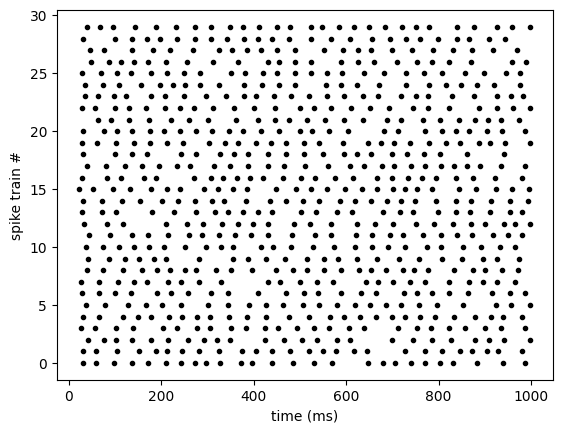

In [17]:
sigma = 200.
sim_time = 1000.
t_spikes = []

for idx in range(30):
    t_s, t_vm, Vms = build_network_noise(I_e, 0., sigma, 1234 + 10 * idx, sim_time=sim_time)
    t_spikes.append(t_s)
    
plt.close("all")
plt.subplot(111, xlabel="time (ms)", ylabel="spike train #")

for idx, t_sp in enumerate(t_spikes):
    plt.plot(t_sp, idx * np.ones_like(t_sp), 'k.')

# Task 3

In [18]:
def build_network3(ts, wd, we, wa, dd=1., de=1., da=1.):
    nest.ResetKernel()
    d = nest.Create('iaf_psc_delta')
    e = nest.Create('iaf_psc_exp')
    a = nest.Create('iaf_psc_alpha')
    nrns = d + e + a
    vms = nest.Create('voltmeter', n=3, params={'interval': 0.1})
    sds = nest.Create('spike_recorder', n=3)
    sg = nest.Create('spike_generator', params={'spike_times': ts})
    nest.Connect(vms, nrns, 'one_to_one')
    nest.Connect(nrns, sds, 'one_to_one')
    
    nest.Connect(sg, d, syn_spec={'weight': wd, 'delay': dd})
    nest.Connect(sg, e, syn_spec={'weight': we, 'delay': de})
    nest.Connect(sg, a, syn_spec={'weight': wa, 'delay': da})
    
    return vms, sds

### Task 3.1

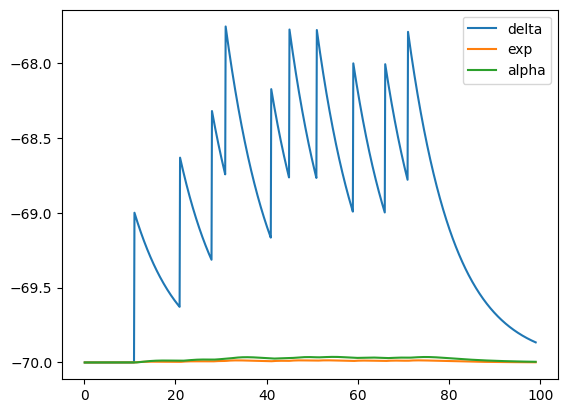

In [19]:
ts = [10., 20., 27., 30., 40., 44., 50., 58., 65., 70.]
vms, _ = build_network3(ts, 1., 1., 1.)
nest.Simulate(100)

vm_stat = nest.GetStatus(vms, 'events')
t_Vm = vm_stat[0]['times']
Vm_delta, Vm_exp, Vm_alpha = vm_stat[0]['V_m'], vm_stat[1]['V_m'], vm_stat[2]['V_m']
plt.plot(t_Vm, Vm_delta, label='delta')
plt.plot(t_Vm, Vm_exp, label='exp')
plt.plot(t_Vm, Vm_alpha, label='alpha')
plt.legend()

Note that the different neuron models respond very differently to the same synaptic weigth

### Task 3.2

In [20]:
def task_3_2(ts, wd, we, wa, dd=1., de=1., da=1.):
    vms, sds = build_network3(ts, wd, we, wa, dd, de, da)
    nest.Simulate(100)
    vm_stat = nest.GetStatus(vms, 'events')
    t_Vm = vm_stat[0]['times']
    Vm_delta, Vm_exp, Vm_alpha = vm_stat[0]['V_m'], vm_stat[1]['V_m'], vm_stat[2]['V_m']
    sd_stat = nest.GetStatus(sds, 'events')
    sp_delta, sp_exp, sp_alpha = sd_stat[0]['times'], sd_stat[1]['times'], sd_stat[2]['times']
    print("""
        Delta: {} spikes {}
        Exp : {} spikes {}
        Alpha: {} spikes {}
    """.format(len(sp_delta), sp_delta, len(sp_exp), sp_exp, len(sp_alpha), sp_alpha))
    plt.plot(t_Vm, Vm_delta, label='delta')
    plt.plot(t_Vm, Vm_exp, label='exp')
    plt.plot(t_Vm, Vm_alpha, label='alpha')
    plt.plot(sp_delta, -54 * np.ones_like(sp_delta), 'bo')
    plt.plot(sp_exp, -53 * np.ones_like(sp_exp), 'go')
    plt.plot(sp_alpha, -52 * np.ones_like(sp_alpha), 'ro')
    plt.ylim(-71, -51)


        Delta: 10 spikes [11. 21. 28. 31. 41. 45. 51. 59. 66. 71.]
        Exp : 10 spikes [12.5 22.  28.9 32.  41.9 45.9 51.8 59.8 66.8 71.8]
        Alpha: 10 spikes [14.6 23.6 30.1 33.9 42.9 47.1 52.6 60.4 67.4 72.5]
    


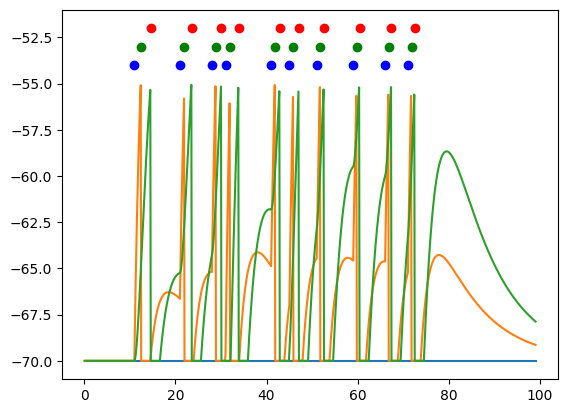

In [21]:
task_3_2(ts, 15., 4000., 1500.)

Note that the membrane potential for the delta synapse (blue) always looks like it zero. That is because each synaptic input takes it directly from rest to threshold where it is reset. You can therefore only see the spikes as blue dots. Note that the spike times for the delta synapse neuron are always 1 ms (1 synaptic delay) after the synaptic input times (given earlier).

It is not possible to get identical spike times for the three neuron types, because the delta synapse is essentially memory-free in this case, while the membrane potential in the other neurons are dependent on previous synaptic input. This can be seen: For the first spike, the times are further apart for the three neurons than is the case for the last spike time. Adjusting the synaptic delay would shift all inputs with the same amount, and never give identical spike times. 

# Task 4

In [22]:
def build_network4(rE, rI, wEd, wEe, wEa, wId, wIe, wIa):
    nest.ResetKernel()
    nest.rng_seed = 12346373
    d = nest.Create('iaf_psc_delta')
    e = nest.Create('iaf_psc_exp')
    a = nest.Create('iaf_psc_alpha')
    nrns = d + e + a
    
    pgE = nest.Create('poisson_generator', params={'rate': rE})
    pgI = nest.Create('poisson_generator', params={'rate': rI})
    pnE = nest.Create('parrot_neuron')
    pnI = nest.Create('parrot_neuron')
    
    nest.Connect(pgE, pnE)
    nest.Connect(pgI, pnI)
    nest.Connect(pnE, d, syn_spec={'weight': wEd})
    nest.Connect(pnI, d, syn_spec={'weight': wId})
    nest.Connect(pnE, e, syn_spec={'weight': wEe})
    nest.Connect(pnI, e, syn_spec={'weight': wIe})
    nest.Connect(pnE, a, syn_spec={'weight': wEa})
    nest.Connect(pnI, a, syn_spec={'weight': wIa})
    
    vms = nest.Create('voltmeter', n=3, params={'interval': 0.1})
    sds = nest.Create('spike_recorder', n=3)
    nest.Connect(vms, nrns, 'one_to_one')
    nest.Connect(nrns, sds, 'one_to_one')
    
    return vms, sds

In [23]:

def task_4_rate(sim_time, rE, rI, wEd, wEe, wEa, wId, wIe, wIa):
    _, sds = build_network4(rE, rI, wEd, wEe, wEa, wId, wIe, wIa)
    nest.Simulate(sim_time)
    rates = [nsp / sim_time * 1000 for nsp in nest.GetStatus(sds, 'n_events')]
    print("""
    Delta: {} 1/s
    Exp : {} 1/s
    Alpha: {} 1/s
    """.format(rates[0], rates[1], rates[2]))

### Task 4.1

In [24]:
task_4_rate(10000., 1000., 0., 2.7, 370., 132., 0., 0., 0.)


    Delta: 98.0 1/s
    Exp : 100.6 1/s
    Alpha: 98.19999999999999 1/s
    


### Task 4.2

In [25]:
task_4_rate(10000., 1000., 1000., 2.7, 370., 132., -1.8, -215., -70.)


    Delta: 32.2 1/s
    Exp : 31.099999999999998 1/s
    Alpha: 30.599999999999998 1/s
    


### Task 4.3


Delta: 7 spikes [ 26.2  69.9  86.  131.8 146.1 161.8 189.5]
Exp : 7 spikes [ 26.8  70.8  81.3 132.5 147.5 162.2 190.8]
Alpha: 6 spikes [ 27.8  72.1  81.9 134.2 149.3 163. ]



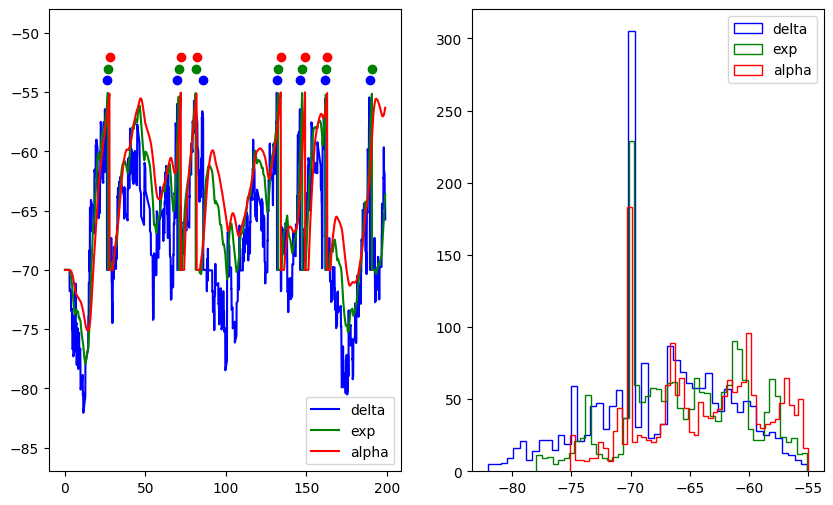

In [26]:
vms, sds = build_network4(1000., 1000., 2.7, 370., 132., -1.8, -215., -70.)
nest.Simulate(200)

vm_stat = nest.GetStatus(vms, 'events')
t_Vm = vm_stat[0]['times']
Vm_delta, Vm_exp, Vm_alpha = vm_stat[0]['V_m'], vm_stat[1]['V_m'], vm_stat[2]['V_m']
sd_stat = nest.GetStatus(sds, 'events')
sp_delta, sp_exp, sp_alpha = sd_stat[0]['times'], sd_stat[1]['times'], sd_stat[2]['times']
print("""
Delta: {} spikes {}
Exp : {} spikes {}
Alpha: {} spikes {}
""".format(len(sp_delta), sp_delta, len(sp_exp), sp_exp, len(sp_alpha), sp_alpha))
plt.figure(figsize=[10, 6])
plt.subplot(121)
plt.plot(t_Vm, Vm_delta, label='delta', c='b')
plt.plot(t_Vm, Vm_exp, label='exp', c='g')
plt.plot(t_Vm, Vm_alpha, label='alpha', c='r')
plt.plot(sp_delta, -54 * np.ones_like(sp_delta), 'bo')
plt.plot(sp_exp, -53 * np.ones_like(sp_exp), 'go')
plt.plot(sp_alpha, -52 * np.ones_like(sp_alpha), 'ro')
plt.ylim(-87, -48)
plt.legend()

plt.subplot(122)
plt.hist(Vm_delta, bins=50, histtype='step', label='delta', color='b')
plt.hist(Vm_exp, bins=50, histtype='step', label='exp', color='g')
plt.hist(Vm_alpha, bins=50, histtype='step', label='alpha', color='r')
plt.legend()

Note that the delta synapse neuron gives a much more "noisy" signal, whereas the exponential, and even more the alpha synapse neurons give a more smooth curve. This is because the synaptic currents in the latter cases are spread out in time. This also means that synaptic input that arrives when the neurons are held at the reset potential (refractory period) are completely lost of the delta neuron, which is not the case for the exp and alpha neuron. This can partly be seen by staring at the left panel. This essentially leads to more input being lost for the delta neuron, which explains why the membrane potential histogram has more negative values (right panel). 

### Task 4.4

Text(0.5, 1.0, 'Input-output relationship')

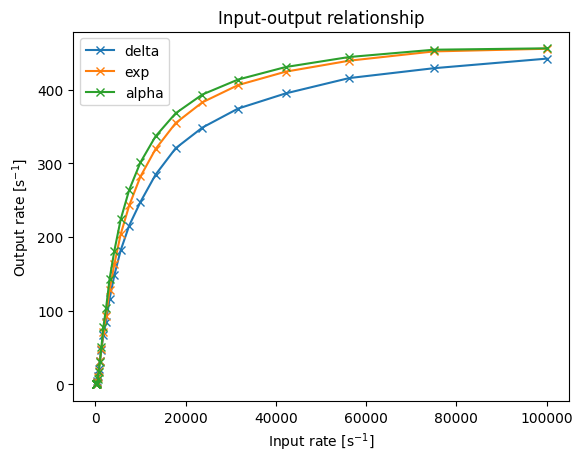

In [27]:
r_in = np.logspace(2, 5, num=25)
r_d = np.nan * np.ones_like(r_in)
r_e = np.nan * np.ones_like(r_in)
r_a = np.nan * np.ones_like(r_in)
sim_time = 10000.
for idx, r in enumerate(r_in):
    _, sds = build_network4(r, r, 2.7, 370., 132., -1.8, -215., -70.)
    nest.Simulate(sim_time)
    n_d, n_e, n_a = nest.GetStatus(sds, 'n_events')
    r_d[idx] = n_d / sim_time * 1000.
    r_e[idx] = n_e / sim_time * 1000.
    r_a[idx] = n_a / sim_time * 1000.
    
plt.plot(r_in, r_d, 'x-', label='delta')
plt.plot(r_in, r_e, 'x-', label='exp')
plt.plot(r_in, r_a, 'x-', label='alpha')
plt.xlabel('Input rate [s$^{-1}$]')
plt.ylabel('Output rate [s$^{-1}$]')
plt.legend()
plt.title('Input-output relationship')

The "delta" curve lies below the other curves, essentially because more input is lost during the refractory period, as mentioned above.